In [1]:
%matplotlib inline

import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
class File:
    def __init__(self, fid, size):
        self.fid = fid                              # 文件惟一id, 从0开始
        self.size = size                            # 文件大小

In [3]:
class Client:                                       # 用户端 请求文件
    def __init__(self, file_num, request_num, balenced=True):
        self.file_num = file_num                    # 文件池数量
        self.request_num = request_num              # trace请求数
        self.file_pool = []                         # 文件池
        self.file_pool_size = 0                     # 文件池总文件大小
        self.trace = np.zeros(shape=(file_num, request_num), dtype=np.int32)     # trace
        self.balenced = balenced
        self.__make_files__()
        self.__make_trace__()

    def __make_files__(self):                       # 生成文件池
        for i in range(self.file_num):
            file = File(i, int(np.random.exponential(scale=100)))    # 文件大小负指数分布
            self.file_pool.append(file)
            self.file_pool_size += file.size
    
    def __frac_exp__(self, s=0.5):
        res = np.random.rand() * np.random.exponential(scale=s)
        while res >= 1:
            res = np.random.rand() * np.random.exponential(scale=s)
        return res

    def __make_trace__(self):  # 生成trace
        for file in range(self.file_num):
            request_peaks = int(np.random.randint(1, self.request_num // 100) * np.random.exponential(scale=0.2))
            if request_peaks <= 1:
                continue
            gap = self.request_num // request_peaks
            for peak in range(request_peaks):
                front = peak * gap
                back = front + gap
                mid = np.random.randint(front, back)
                if self.balenced:
                    start = mid - int(self.__frac_exp__(0.5) * (mid - front))
                    end = mid + int(self.__frac_exp__(0.5) * (back - mid))
                else:
                    if file & 0b01: # 小 cache a 的工作量大一些
                        start = mid - int(self.__frac_exp__(0.7) * (mid - front))
                        end = mid + int(self.__frac_exp__(0.7) * (back - mid))
                    else:
                        start = mid - int(self.__frac_exp__(0.2) * (mid - front))
                        end = mid + int(self.__frac_exp__(0.2) * (back - mid))
                for time in range(start, end):
                    self.trace[file][time] = 1
        self.trace = self.trace.reshape((self.request_num, self.file_num))

    def make_requests(self):                        # 迭代器 产生文件请求流
        for time in self.trace:
            for i in range(self.file_num):
                if time[i]:
                    yield self.file_pool[i]

In [4]:
class Server:                                       # 服务器(cache)
    def __init__(self, space):
        self.space = space                          # cache大小
        self.remain = space                         # cache剩余空间
        self.cache = OrderedDict()                  # OrderDict() 模拟cache LRU方法
        self.hit_count = 0                          # 命中次数
        self.miss_count = 0                         # 未命中次数

    def _hit(self, key):
        self.hit_count += 1
        self.cache.move_to_end(key)

    def _miss(self, file):
        self.miss_count += 1
        while self.remain < file.size:
            self.remain += self.cache.popitem(last=False)[-1]  # pop出第一个item
        self.cache[file.fid] = file.size
        self.remain -= file.size

    def handle(self, file):                         # 处理一次请求
        if file.fid in self.cache.keys():
            self._hit(file.fid)
        else:
            self._miss(file)

    def hit_rate(self):
        try:
            return self.hit_count / (self.hit_count + self.miss_count)
        except:
            return "Server has not been requested yet!"

In [5]:
FILE_NUM = int(1e2)
REQUEST_NUM = int(1e4)

In [6]:
client_balenced = Client(FILE_NUM, REQUEST_NUM)
client_imbalenced = Client(FILE_NUM, REQUEST_NUM, False)

In [7]:
print(client_balenced.file_pool_size)
print(client_imbalenced.file_pool_size)

8875
9377


Balanced Trace

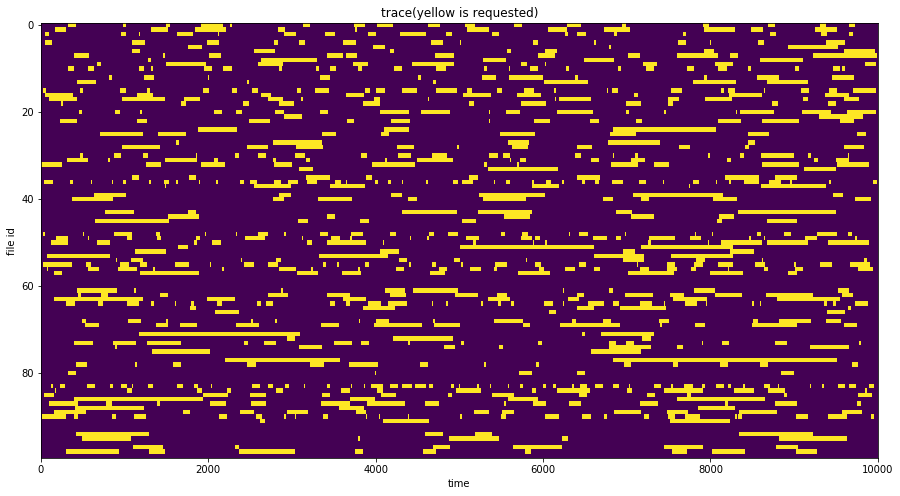

In [8]:
plt.figure(figsize=(15, 8))
plt.xlabel("time")
plt.ylabel("file id")
plt.title("trace(yellow is requested)")
plt.imshow(client_balenced.trace.reshape((FILE_NUM, REQUEST_NUM)), aspect='auto')

imbalenced trace

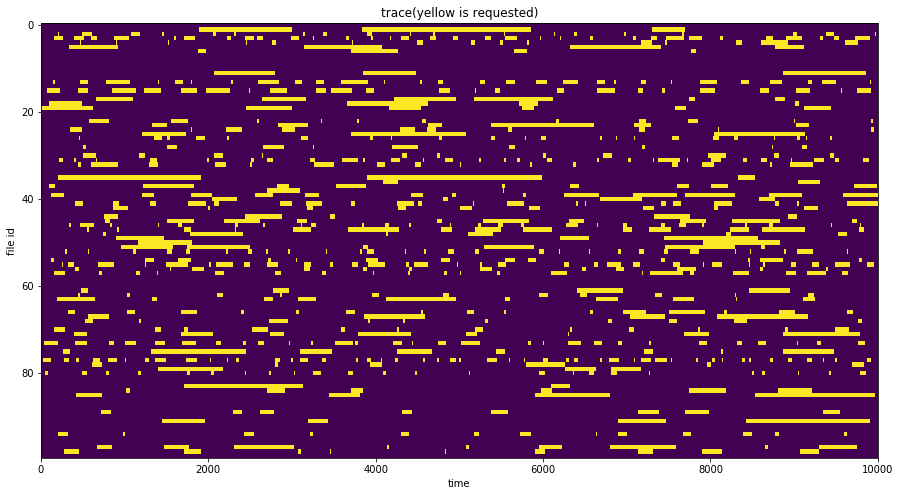

In [9]:
plt.figure(figsize=(15, 8))
plt.xlabel("time")
plt.ylabel("file id")
plt.title("trace(yellow is requested)")
plt.imshow(client_imbalenced.trace.reshape((FILE_NUM, REQUEST_NUM)), aspect='auto')

In [10]:
little_server_a_hit_rate = []
little_server_b_hit_rate = []
big_server_hit_rate = []
cache_size_array = []
for cache_size in range(client_balenced.file_pool_size // 10, client_balenced.file_pool_size // 3, client_balenced.file_pool_size // 100):
    cache_size_array.append(cache_size / client_balenced.file_pool_size)
    little_server_a = Server(cache_size)
    little_server_b = Server(cache_size)
    big_server = Server(cache_size * 2)
    for request_file in client_balenced.make_requests():
        if request_file.fid & 0b10:
            little_server_a.handle(request_file)
        else:
            little_server_b.handle(request_file)
    little_server_a_hit_rate.append(little_server_a.hit_rate())
    little_server_b_hit_rate.append(little_server_b.hit_rate())
    for request_file in client_balenced.make_requests():
        big_server.handle(request_file)
    big_server_hit_rate.append(big_server.hit_rate())

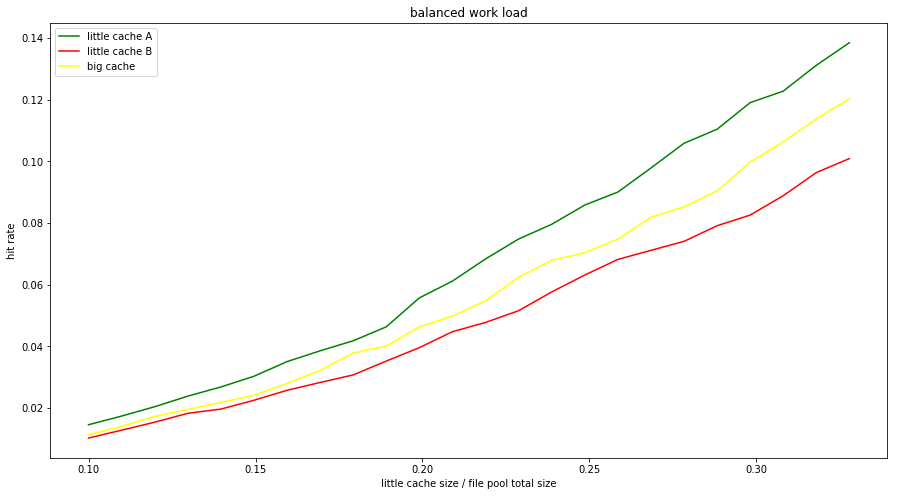

In [11]:
plt.figure(figsize=(15,8))
plt.plot(cache_size_array, little_server_a_hit_rate, color='green', label='little cache A')
plt.plot(cache_size_array, little_server_b_hit_rate, color='red', label='little cache B')
plt.plot(cache_size_array, big_server_hit_rate, color='yellow', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit rate")
plt.title("balanced work load")
plt.legend()

In [12]:
little_server_a_hit_rate = []
little_server_b_hit_rate = []
big_server_hit_rate = []
cache_size_array = []
for cache_size in range(client_imbalenced.file_pool_size // 10, client_imbalenced.file_pool_size // 3, client_imbalenced.file_pool_size // 100):
    cache_size_array.append(cache_size / client_imbalenced.file_pool_size)
    little_server_a = Server(cache_size)
    little_server_b = Server(cache_size)
    big_server = Server(cache_size * 2)
    for request_file in client_imbalenced.make_requests():
        if request_file.fid & 0b10:
            little_server_a.handle(request_file)
        else:
            little_server_b.handle(request_file)
    little_server_a_hit_rate.append(little_server_a.hit_rate())
    little_server_b_hit_rate.append(little_server_b.hit_rate())
    for request_file in client_imbalenced.make_requests():
        big_server.handle(request_file)
    big_server_hit_rate.append(big_server.hit_rate())

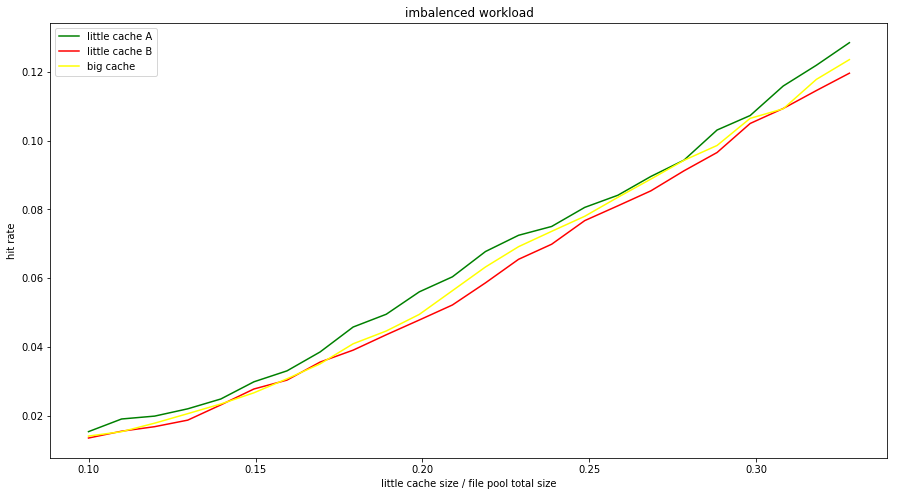

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(cache_size_array, little_server_a_hit_rate, color='green', label='little cache A')
plt.plot(cache_size_array, little_server_b_hit_rate, color='red', label='little cache B')
plt.plot(cache_size_array, big_server_hit_rate, color='yellow', label='big cache')
plt.xlabel("little cache size / file pool total size")
plt.ylabel("hit rate")
plt.title("imbalenced workload")
plt.legend()
plt.show()